In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

import random
from typing import List, Tuple
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [2]:
# Path to your DTD dataset (downloaded and extracted)

DATASET_PATH = f"{os.getcwd()}/ambient-cg-images"
DATASET_PATH

'C:\\Projects\\Texture-SuperResolution/ambient-cg-images'

In [3]:
# -----------------------------
# 🔹 Preprocessing Function
# -----------------------------
IMAGE_LIMIT = 100

def load_dtd_dataset(root_dir, scale_factor=2, patch_size=64, test_size=0.2):
    """
    Loads DTD dataset and creates LR-HR pairs as numpy arrays.
    """
    image_files = []
    counter = 0
    for root, _, files in os.walk(root_dir):
        if counter > IMAGE_LIMIT:
            break
        for f in files:
            if counter > IMAGE_LIMIT:
                break
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(os.path.join(root, f))
                counter += 1
                
    to_tensor = transforms.ToTensor()
    X, Y = [], []

    for img_path in image_files:
        hr_img = Image.open(img_path).convert("RGB")
        width, height = hr_img.size

        # Ensure patch fits
        if width < patch_size or height < patch_size:
            hr_img = hr_img.resize((patch_size, patch_size), Image.BICUBIC)
        else:
            # Random crop
            left = np.random.randint(0, width - patch_size + 1)
            top = np.random.randint(0, height - patch_size + 1)
            hr_img = hr_img.crop((left, top, left + patch_size, top + patch_size))

        # Create low-res version
        lr_size = (patch_size // scale_factor, patch_size // scale_factor)
        lr_img = hr_img.resize(lr_size, Image.BICUBIC)
        lr_img = lr_img.resize((patch_size, patch_size), Image.BICUBIC)

        # Convert to tensors (C,H,W) and append
        X.append(to_tensor(lr_img).numpy())
        Y.append(to_tensor(hr_img).numpy())

    X = np.array(X, dtype=np.float32)
    Y = np.array(Y, dtype=np.float32)

    # Train/val split
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=test_size, random_state=42)

    return X_train, X_val, Y_train, Y_val

X_train, X_val, Y_train, Y_val = load_dtd_dataset(DATASET_PATH, scale_factor=3, patch_size=64)

C:\Users\neelr\AppData\Roaming\Python\Python313\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (150994944 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [4]:
class TextureDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X)  # convert to torch.Tensor
        self.Y = torch.from_numpy(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.Y[i]

In [5]:
train_dataset = TextureDataset(X_train, Y_train)
val_dataset = TextureDataset(X_val, Y_val)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))

# Test one sample
lr, hr = train_dataset[56]
print("LR shape:", lr.shape, "HR shape:", hr.shape)

Train samples: 80
Val samples: 21
LR shape: torch.Size([3, 64, 64]) HR shape: torch.Size([3, 64, 64])


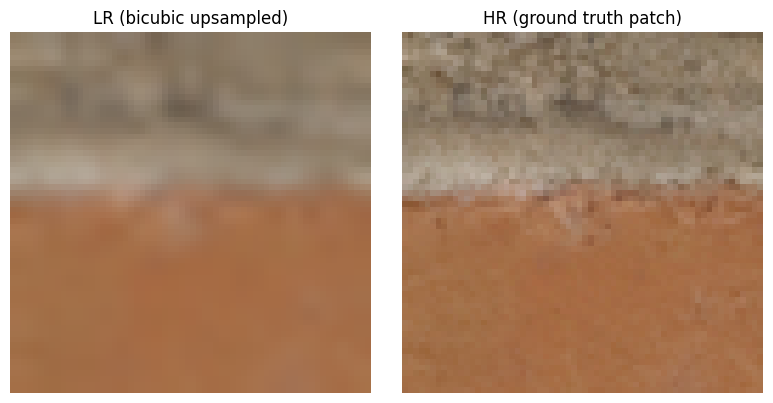

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(np.transpose(lr.numpy(), (1, 2, 0)))
axes[0].set_title("LR (bicubic upsampled)")
axes[0].axis("off")
axes[1].imshow(np.transpose(hr.numpy(), (1, 2, 0)))
axes[1].set_title("HR (ground truth patch)")
axes[1].axis("off")
plt.tight_layout()
plt.show()

In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [8]:
from model import SRCNN

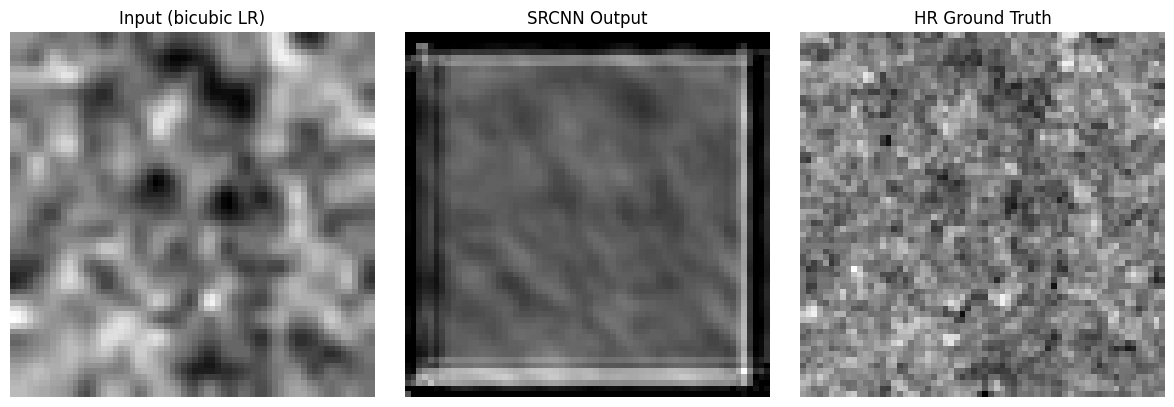

PSNR(bicubic→HR): 32.39 dB, PSNR(SRCNN→HR): 10.99 dB


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Your SRCNN class should already be defined above.
model = SRCNN(num_channels=1).to(device)  # set to 3 if you trained RGB

def rgb_to_y(t: torch.Tensor) -> torch.Tensor:
    """t: [C,H,W] in [0,1]; returns [1,H,W] luminance (BT.601)."""
    if t.dim() == 3 and t.shape[0] == 3:
        r, g, b = t[0], t[1], t[2]
        y = 0.299 * r + 0.587 * g + 0.114 * b
        return y.unsqueeze(0)
    return t  # already single-channel

def to_hwc_np(t: torch.Tensor):
    """[C,H,W] -> HxW(c) numpy for imshow."""
    t = t.detach().cpu()
    if t.shape[0] == 1:
        return t.squeeze(0).numpy()
    return np.transpose(t.numpy(), (1, 2, 0))


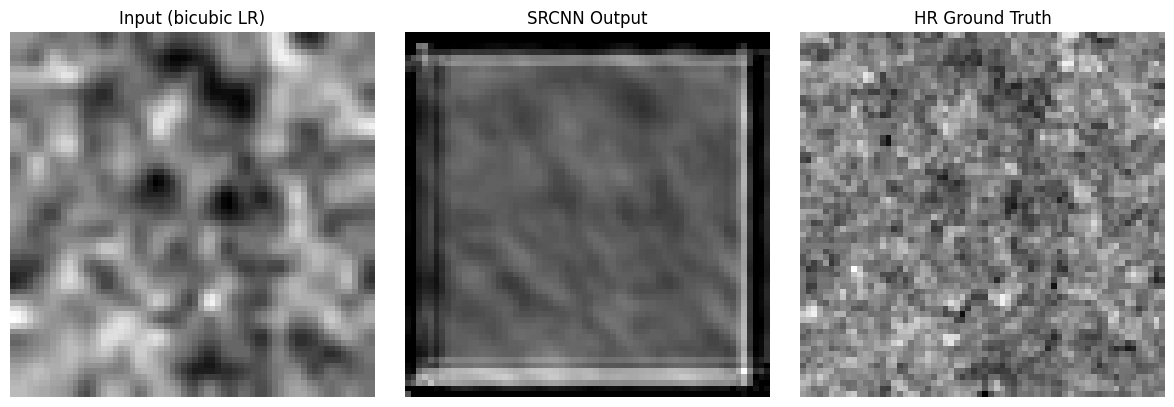

PSNR(bicubic→HR): 32.39 dB, PSNR(SRCNN→HR): 10.99 dB


In [26]:
# --- Grab one sample from your dataset ---
sample = train_dataset[1]  # or val_dataset[0]
if isinstance(sample, (tuple, list)) and len(sample) >= 2:
    lr, hr = sample[0], sample[1]
else:
    raise ValueError("Dataset should return (lr, hr) or (lr, hr, name).")

# Prepare input according to model channel count
if model.conv1.in_channels == 1:
    lr_in = rgb_to_y(lr)   # [1,H,W]
    hr_vis = rgb_to_y(hr)  # for fair comparison/plotting
else:
    lr_in = lr             # [3,H,W]
    hr_vis = hr

# --- Forward pass ---
with torch.no_grad():
    sr = model(lr_in.unsqueeze(0).to(device)).clamp(0, 1).squeeze(0).cpu()

# --- Visualize ---
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(to_hwc_np(lr_in), cmap="gray" if lr_in.shape[0]==1 else None)
axes[0].set_title("Input (bicubic LR)")
axes[0].axis("off")
axes[1].imshow(to_hwc_np(sr), cmap="gray" if sr.shape[0]==1 else None)
axes[1].set_title("SRCNN Output")
axes[1].axis("off")
axes[2].imshow(to_hwc_np(hr_vis), cmap="gray" if hr_vis.shape[0]==1 else None)
axes[2].set_title("HR Ground Truth")
axes[2].axis("off")
plt.tight_layout()
plt.show()

# (Optional) quick PSNR check
def psnr(a: torch.Tensor, b: torch.Tensor, eps=1e-10):
    mse = torch.mean((a - b) ** 2).item()
    return 20 * np.log10(1.0 / np.sqrt(mse + eps))
print(f"PSNR(bicubic→HR): {psnr(lr_in, hr_vis):.2f} dB, PSNR(SRCNN→HR): {psnr(sr, hr_vis):.2f} dB")